<a id="imports"></a>

# Spotify + Billboard Hot 100

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [178]:
import pandas as pd
from tqdm import tqdm
import os
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from scipy import stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score


from IPython.display import display, Markdown

<a id="definitions"></a> [Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [2]:
def load_csv_file(filename):
    try:
        if not os.path.exists(filename):
            print(f"The file: {filename} doesn't exist")
        else:
            print("Found File")
            return pd.concat([chunk for chunk in tqdm(pd.read_csv(filename, chunksize=1000), desc=f'Loading {filename}')])
    except:
        print("Didn't Work! :(")

In [3]:
def rename_columns(df):
    new_names = []

    for column in df.columns:
        level_one = re.sub('(?<!^)(?=[A-Z])', '_', column).lower()
        level_one = re.sub(' ', '_',level_one)
        level_one = re.sub(' _', '_',level_one)
        level_one = re.sub('__','_',level_one)
        new_names.append(level_one)
    df.columns = new_names
    return df

In [4]:
def data_dictionary(df):
    # Printing a data dictionary using a printout of each column name
    # formatted as a MarkDown table
    # =================================================================

    # variable to hold size of longest string in dataframe column names
    size_longest_name = len((max((df.columns.to_list()), key = len)))

    # head of markdown table
    print(f"| {'Name' : <{size_longest_name}} | Definition |")
    print(f"| {'-'*size_longest_name} | {'-'*len('Definition')} |")

    # dataframe column content
    for i in (df.columns.to_list()):
        print(f"| {i : <{size_longest_name}} | Definition |")

In [5]:
def plot_clust(df):
    num, cat = separate_column_type_list(df)
    train_scaled = df[num]
    # Create Object
    mm_scaler = MinMaxScaler()
    train_scaled[num] = mm_scaler.fit_transform(train_scaled[num])
    seed = 42
    cluster_count = 4

    kmeans = KMeans(n_clusters=cluster_count,random_state=seed)
    kmeans.fit(train_scaled)
    df['clusters']=kmeans.predict(train_scaled)
    sns.boxplot(data=df,x='clusters',y='alcohol',hue='quality')
    plt.title("What about Clustering?")
    plt.show()

In [82]:
def flatten(list_2d):
    '''
    Function that allows other functions to accept a list as an argument
    and not cause pesky 2d-List issues when appending a list to the 
    original argument list
    '''
    flattened = []
    for item in list_2d:
        if isinstance(item,list): flattened.extend(flatten(item))
        else: flattened.append(item)
    return flattened

In [6]:
def split_data(df):
    '''
    This function take in a dataframe and splits into train validate test
    '''
    
    # create train_validate and test datasets
    train, test = train_test_split(df, train_size = 0.8, random_state = 123)
    
    # create train and validate datasets
    train, validate = train_test_split(train, train_size = 0.7, random_state = 123)
    
    # sanity check
    print(train.shape,validate.shape,test.shape)
    
    return train, validate, test

In [7]:
def isolate_target(df, target):
    '''
    splits datasets into X,y
    '''
    
    #Split into X and y
    X = df.drop(columns=[target])
    y = df[target]

    # sanity check
    print(X.shape,y.shape)
    
    return X,y

[Dummies](#get_dummies) <a id="dummy_def"></a>

In [85]:
def dummies(df,dummies):
    # keeper columns are numerical & discrete chosen
    # for dummy creation
    numerical = df.select_dtypes('number').columns
    keepers = df[numerical].columns.to_list()
    keepers.append(dummies)
    
    # fix list to be useable as column index
    keepers = flatten(keepers)
    
    # Create dummies for non-binary categorical columns
    df[dummies]=pd.get_dummies(df[dummies], drop_first = True)
    
    # drop redundant column
    df = df.drop(df.columns.difference(keepers),axis=1)
    
    return df

In [9]:
def eval_results(p, alpha, group1, group2):
    '''
        Test Hypothesis  using Statistics Test Output.
        This function will take in the p-value, alpha, and a name for the 2 variables
        you are comparing (group1 and group2) and return a string stating 
        whether or not there exists a relationship between the 2 groups. 
    '''
    if p < alpha:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Reject $H_0$"))
        display(Markdown( f'There exists some relationship between {group1} and {group2}. (p-value: {p:.4f})'))
    
    else:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Failed to Reject $H_0$"))
        display(Markdown( f'There is not a significant relationship between {group1} and {group2}. (p-value: {p:.4f})'))

In [10]:
def separate_column_type_list(df):
    '''
        Creates 2 lists separating continous & discrete
        variables.
        
        Parameters
        ----------
        df : Pandas DataFrame
            The DataFrame from which columns will be sorted.
        
        Returns
        ----------
        continuous_columns : list
            Columns in DataFrame with numerical values.
        discrete_columns : list
            Columns in DataFrame with categorical values.
    '''
    continuous_columns = []
    discrete_columns = []
    
    for column in df.columns:
        if (df[column].dtype == 'int' or df[column].dtype == 'float') and ('id' not in column) and (df[column].nunique()>10):
            continuous_columns.append(column)
        elif(df[column].dtype == 'int' or df[column].dtype == 'float') and (df[column].nunique()>11):
            continuous_columns.append(column)
        else:
            discrete_columns.append(column)
            
    return continuous_columns, discrete_columns

<a id="scale_def"></a> [Scale](#scale) - [Lasso](#lasso)

In [195]:
def scale_data(df,mode="minmax"):
    # create a list of only continous features from input DataFrame
    continous = df.select_dtypes('number').columns
    
    if mode == "minmax":
        scaler = sklearn.preprocessing.MinMaxScaler()
        scaler.fit(df[continous])
        df[continous] = scaler.transform(df[continous])
        
        return df

    elif mode == "standard":
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(df[continous])
        df[continous] = scaler.transform(df[continous])
        
        return df
    
    else:
        print("write new code")

[Modeling](#model)

In [12]:
def num_vs_num_visualize(df,feature,target):
    question = f"Does a higher {feature} mean higher {target}?"

    #sns.scatterplot(x=df[feature], y=df[target])
    #plt.suptitle(f"{question}")

    #plt.show()
    
    sns.jointplot(data=df, x=feature, y=target,  kind='reg', height=8)
    plt.show()

In [13]:
def eval_results(p, alpha, group1, group2):
    '''
        Test Hypothesis  using Statistics Test Output.
        This function will take in the p-value, alpha, and a name for the 2 variables
        you are comparing (group1 and group2) and return a string stating 
        whether or not there exists a relationship between the 2 groups. 
    '''
    if p < alpha:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Reject $H_0$"))
        display(Markdown( f'There exists some relationship between {group1} and {group2}. (p-value: {p:.4f})'))
    
    else:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Failed to Reject $H_0$"))
        display(Markdown( f'There is not a significant relationship between {group1} and {group2}. (p-value: {p:.4f})'))

In [14]:
def question_hypothesis_test(question_number,df,feature,target,alpha=.05):
    num, cat = separate_column_type_list(df)
    question = 'temp'
    if (target in cat) and (feature in num):
        # calculation
        overall_alcohol_mean = df[feature].mean()
        quality_sample = df[df[target] >= 7][target]
        t, p = stats.ttest_1samp(quality_sample, overall_alcohol_mean)
        value = t
        p_value = p/2
        
        # Output variables
        test = "1-Sample T-Test"

        # Markdown Format Question
        display(Markdown(f"# Question #{question_number}:"))
        display(Markdown(f"# {question}"))
        
        # Visualize Question

        # Markdown Formatting Metrics
        display(Markdown(f"### Hypothesis:"))
        display(Markdown(f"$H_0$: There is no relationship between `{feature}` and `{target}`"))
        display(Markdown(f"$H_A$: There is a relationship between `{feature}` and `{target}` "))
        display(Markdown(f"### Statistics Test:"))
        display(Markdown(f"### `{test} = {value}`"))

        # Evaluate Results
        eval_results(p_value, alpha, feature, target)

    elif (target in cat) and (feature in cat):
        # calculations
        observed = pd.crosstab(df[feature], df[target])
        chi2, p, degf, expected = stats.chi2_contingency(observed)
        value = chi2
        p_value = p
        
        # Output variables
        test = "Chi-Square"

        # Markdown Formatting
        display(Markdown(f"# Question #{question_number}:"))
        display(Markdown(f"# {question}"))
        display(Markdown(f"### Hypothesis:"))
        display(Markdown(f"$H_0$: There is no relationship between `{feature}` to `{target}`"))
        display(Markdown(f"$H_A$: There is a relationship between `{feature}` and `{target}` "))
        display(Markdown(f"### Statistics Test:"))
        display(Markdown(f"### `{test} = {value}`"))

        eval_results(p_value, alpha, feature, target)

    elif (target in num) and (feature in num):
        # Markdown Format Question
        question = f"Does a higher {feature} mean higher {target}?"
    
        # calculations
        r, p = stats.pearsonr(df[feature], df[target])
        value = r
        p_value = p
        
        # Output variables
        test = "Pearson's R"

        # Output Question
        display(Markdown(f"# Question #{question_number}:"))
        display(Markdown(f"# {question}"))
        
        # Visualize Question
        num_vs_num_visualize(df,feature,target)
        
        # Markdown Format Metrics
        display(Markdown(f"### Hypothesis:"))
        display(Markdown(f"$H_0$: There is no relationship between `{feature}` to `{target}`"))
        display(Markdown(f"$H_A$: There is a relationship between `{feature}` and `{target}` "))
        display(Markdown(f"### Statistics Test:"))
        display(Markdown(f"### `{test} = {value}`"))
    
        # Markdown Format Evaluate Results
        eval_results(p_value, alpha, feature, target)
        display(Markdown("<hr style=\"border:2px solid gray\">"))
    else:
        print("write code for different test")

[Models](#modeling) <a id="model_def"></a>

In [ ]:
# def model():

# Acquire <a id="acquire"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [ ]:
# acquire datasets
hot_100 = pd.read_csv("hot_100.csv")
spotify_popular = pd.read_csv("songs_normalize.csv")

# date type column
hot_100['chart_date']=pd.to_datetime(hot_100['chart_date'])

# set date column as index
hot_100 = hot_100.set_index("chart_date").sort_index()
hot_100_2000_2020 = hot_100.loc['2000-01-01':'2020-12-31']

# create song index
hot_100_2000_2020["song_index"] = hot_100_2000_2020["performer"].str.lower() + " - " + hot_100_2000_2020["song"].str.lower()

#saving extra copy of date before grouping by index
hot_100_2000_2020['date'] = hot_100_2000_2020.index

# Removing Song instance for other weeks besides the most recent
hot_100_2000_2020_only_latest = hot_100_2000_2020.groupby('song_index', group_keys=False).apply(lambda x: x.index[np.argmax(x.index)])

# converting back to dataframe
hot_100_2000_2020_only_latest = pd.DataFrame(hot_100_2000_2020_only_latest)

# swapping back the index
hot_100_2000_2020_only_latest.columns = ["index"]

hot_100_2000_2020_only_latest["unique"]=hot_100_2000_2020_only_latest.index

hot_100_2000_2020_only_latest = hot_100_2000_2020_only_latest.set_index("index").sort_index()
hot_100_2000_2020_only_latest['is_unique'] = 1
hot_100_2000_2020_only_latest['date']=hot_100_2000_2020_only_latest.index
hot_100_2000_2020_only_latest['song_index']=hot_100_2000_2020_only_latest['unique']
hot_100_2000_2020_only_latest = hot_100_2000_2020_only_latest.drop(columns = ['unique'])
merged_hot100_only_latest = hot_100_2000_2020.merge(hot_100_2000_2020_only_latest,how='left')
merged_hot100_only_latest=merged_hot100_only_latest[merged_hot100_only_latest['is_unique']==1]

In [ ]:
merged_hot100_only_latest['1st_split']=merged_hot100_only_latest['performer'].str.split('&').str[0]
merged_hot100_only_latest['2nd_split']=merged_hot100_only_latest['1st_split'].str.split('With').str[0]
merged_hot100_only_latest['3rd_split']=merged_hot100_only_latest['2nd_split'].str.split('Featuring').str[0]
merged_hot100_only_latest['4th_split']=merged_hot100_only_latest['3rd_split'].str.split(',').str[0]
merged_hot100_only_latest['5th_split']=merged_hot100_only_latest['4th_split'].str.split(' x ').str[0]
merged_hot100_only_latest['6th_split']=merged_hot100_only_latest['5th_split'].str.split('+').str[0]
# final split on peformer column is aved as "singer" column to use in Unique ID creation
merged_hot100_only_latest['singer']=merged_hot100_only_latest['6th_split']
# drop old columns used as step/place-holders to isolate Artist/Singer from "Performer" column
merged_hot100_only_latest = merged_hot100_only_latest.drop(columns = ['1st_split','2nd_split','3rd_split','4th_split','5th_split','6th_split'])
# Fixing Song Title mixed characters
merged_hot100_only_latest['song'] = merged_hot100_only_latest['song'].str.replace('[^0-9a-z - A-Z]', '')
# Unique ID from artist & song combination
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['singer'].str.lower() + ' - ' + merged_hot100_only_latest['song'].str.lower()
# standardization for both datasets song_index
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('[^0-9a-z-A-Z]', '')
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('*', '')
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('-', ' - ')

In [ ]:
new_spotify_merge = spotify_popular.merge(merged_hot100_only_latest,how='left',on='song_index')

In [ ]:
merged_data_non_nulls = new_spotify_merge.dropna()

In [ ]:
merged_data_non_nulls.to_csv('merged_data_non_nulls.csv',index=False)

In [15]:
df = load_csv_file("merged_data_non_nulls.csv")

Found File


Loading merged_data_non_nulls.csv: 2it [00:00, 246.36it/s]


### Cleaning Pt. 2

In [16]:
df.rename(columns = {'song_x':'song'}, inplace = True)

In [17]:
df=df.drop(columns=['is_unique','singer','test_y'])

In [18]:
df=df.drop(columns=['performer_x', 'song_index', 'test_x', 'song_y', 'performer_y'])

# Explore <a id="explore"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [19]:
target = 'time_on_chart'

# Question #1:

# Does a higher duration_ms mean higher time_on_chart?

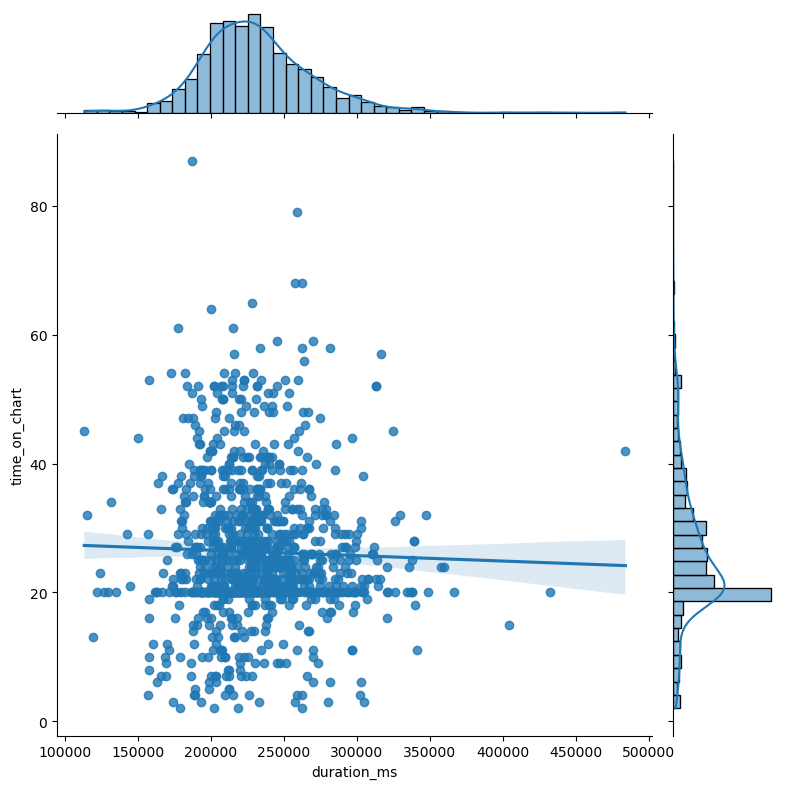

### Hypothesis:

$H_0$: There is no relationship between `duration_ms` to `time_on_chart`

$H_A$: There is a relationship between `duration_ms` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.029301798086126058`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between duration_ms and time_on_chart. (p-value: 0.3274)

<hr style="border:2px solid gray">

# Question #2:

# Does a higher year mean higher time_on_chart?

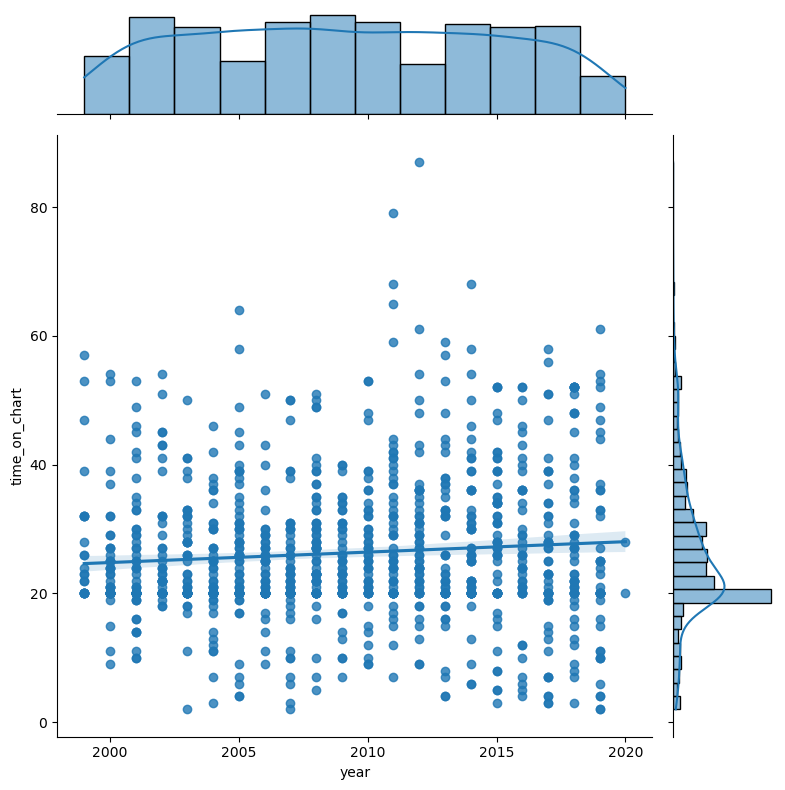

### Hypothesis:

$H_0$: There is no relationship between `year` to `time_on_chart`

$H_A$: There is a relationship between `year` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.08515576037947584`

### Results:

### Reject $H_0$

There exists some relationship between year and time_on_chart. (p-value: 0.0044)

<hr style="border:2px solid gray">

# Question #3:

# Does a higher popularity mean higher time_on_chart?

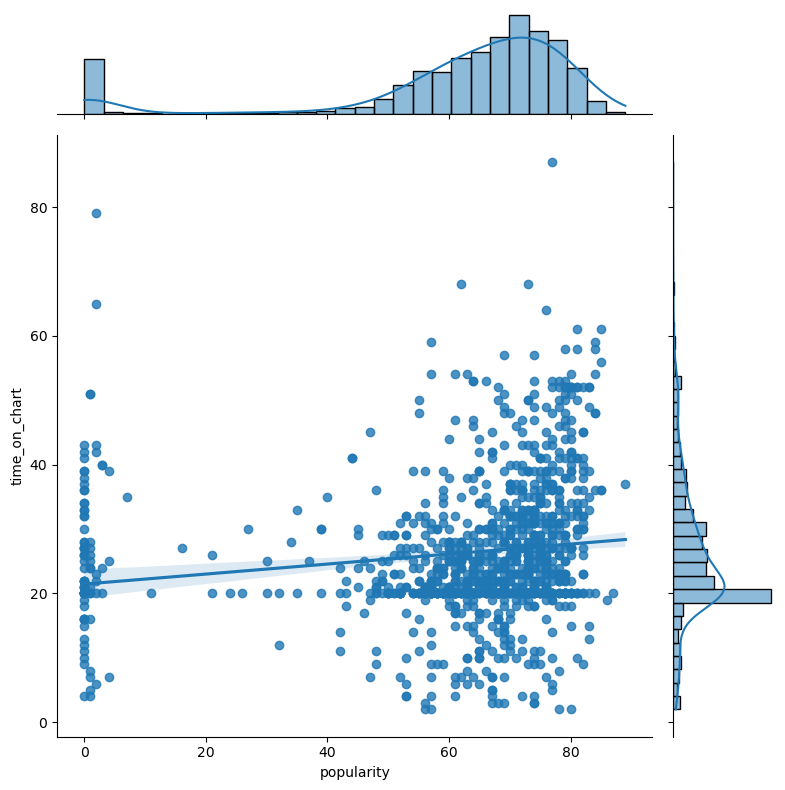

### Hypothesis:

$H_0$: There is no relationship between `popularity` to `time_on_chart`

$H_A$: There is a relationship between `popularity` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.14640714625454787`

### Results:

### Reject $H_0$

There exists some relationship between popularity and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #4:

# Does a higher danceability mean higher time_on_chart?

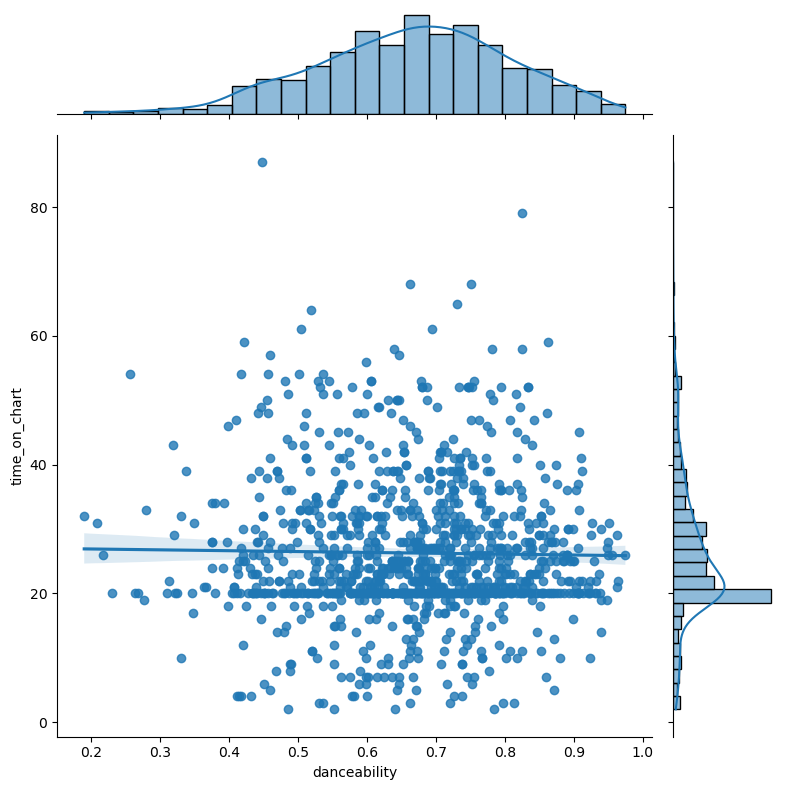

### Hypothesis:

$H_0$: There is no relationship between `danceability` to `time_on_chart`

$H_A$: There is a relationship between `danceability` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.017039593144861975`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between danceability and time_on_chart. (p-value: 0.5691)

<hr style="border:2px solid gray">

# Question #5:

# Does a higher energy mean higher time_on_chart?

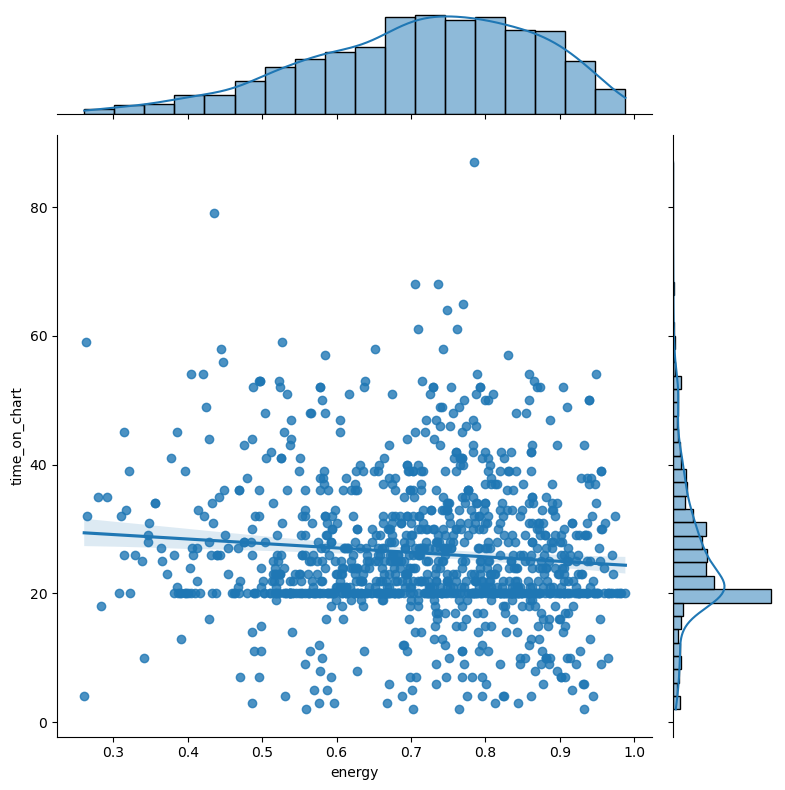

### Hypothesis:

$H_0$: There is no relationship between `energy` to `time_on_chart`

$H_A$: There is a relationship between `energy` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.09449067368126929`

### Results:

### Reject $H_0$

There exists some relationship between energy and time_on_chart. (p-value: 0.0016)

<hr style="border:2px solid gray">

# Question #6:

# Does a higher key mean higher time_on_chart?

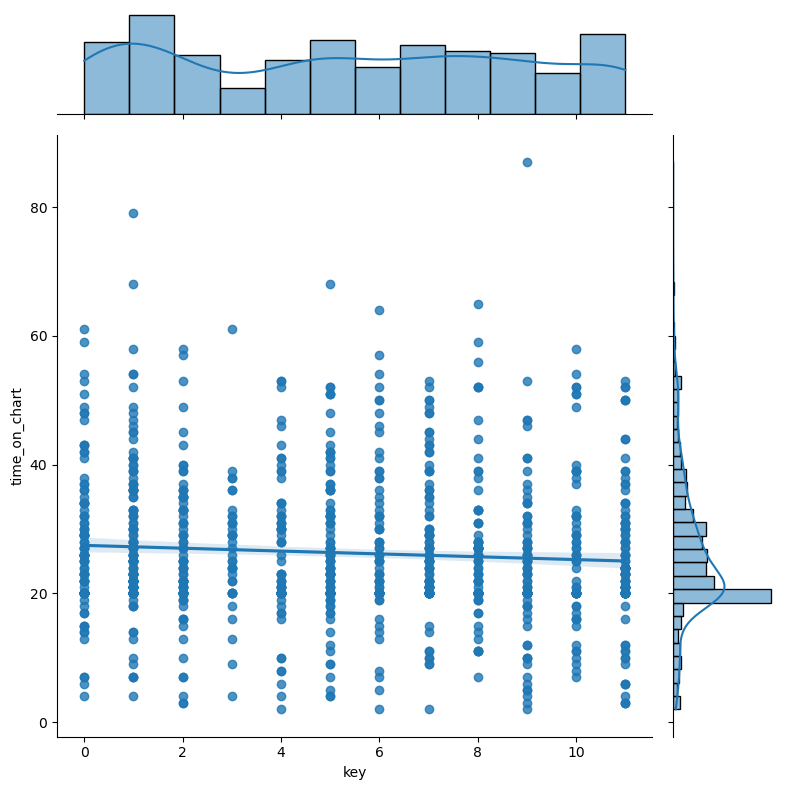

### Hypothesis:

$H_0$: There is no relationship between `key` to `time_on_chart`

$H_A$: There is a relationship between `key` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.07271433578230616`

### Results:

### Reject $H_0$

There exists some relationship between key and time_on_chart. (p-value: 0.0150)

<hr style="border:2px solid gray">

# Question #7:

# Does a higher loudness mean higher time_on_chart?

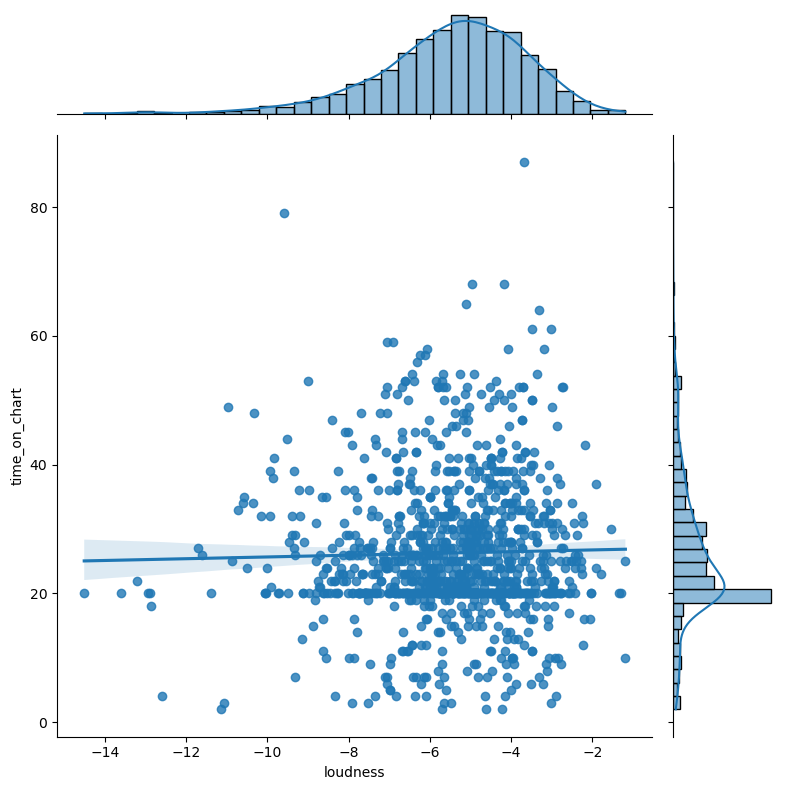

### Hypothesis:

$H_0$: There is no relationship between `loudness` to `time_on_chart`

$H_A$: There is a relationship between `loudness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.022961801860786453`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between loudness and time_on_chart. (p-value: 0.4429)

<hr style="border:2px solid gray">

write code for different test


# Question #9:

# Does a higher speechiness mean higher time_on_chart?

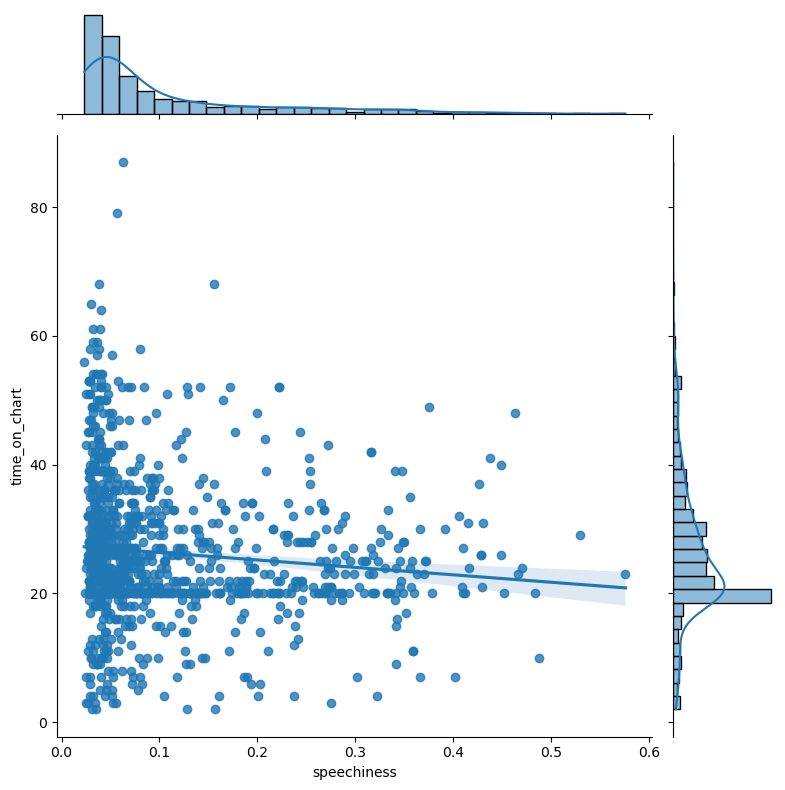

### Hypothesis:

$H_0$: There is no relationship between `speechiness` to `time_on_chart`

$H_A$: There is a relationship between `speechiness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.10471269663659986`

### Results:

### Reject $H_0$

There exists some relationship between speechiness and time_on_chart. (p-value: 0.0005)

<hr style="border:2px solid gray">

# Question #10:

# Does a higher acousticness mean higher time_on_chart?

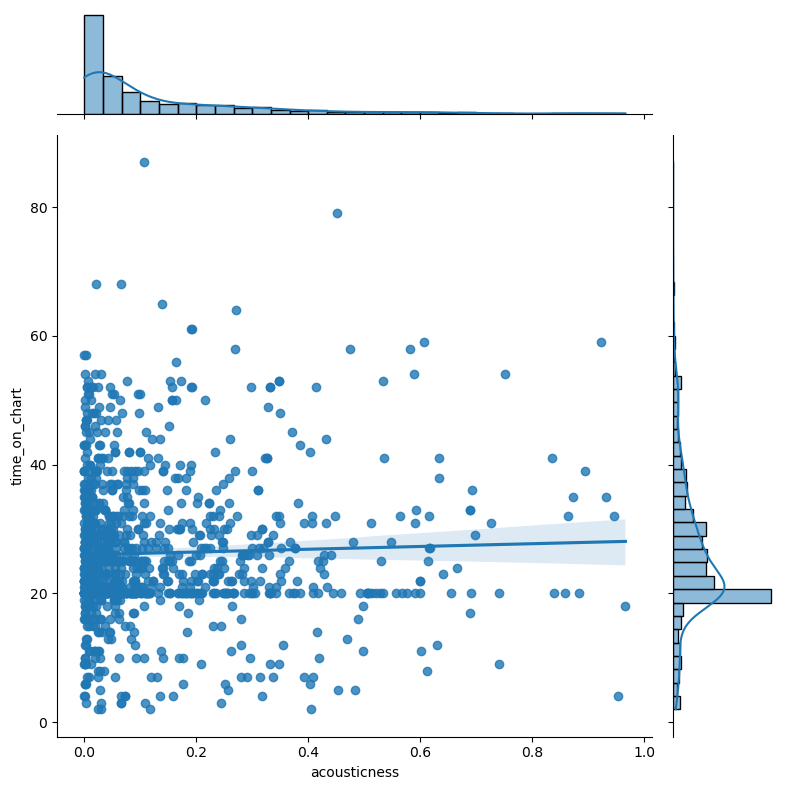

### Hypothesis:

$H_0$: There is no relationship between `acousticness` to `time_on_chart`

$H_A$: There is a relationship between `acousticness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.03377985551602524`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between acousticness and time_on_chart. (p-value: 0.2589)

<hr style="border:2px solid gray">

# Question #11:

# Does a higher instrumentalness mean higher time_on_chart?

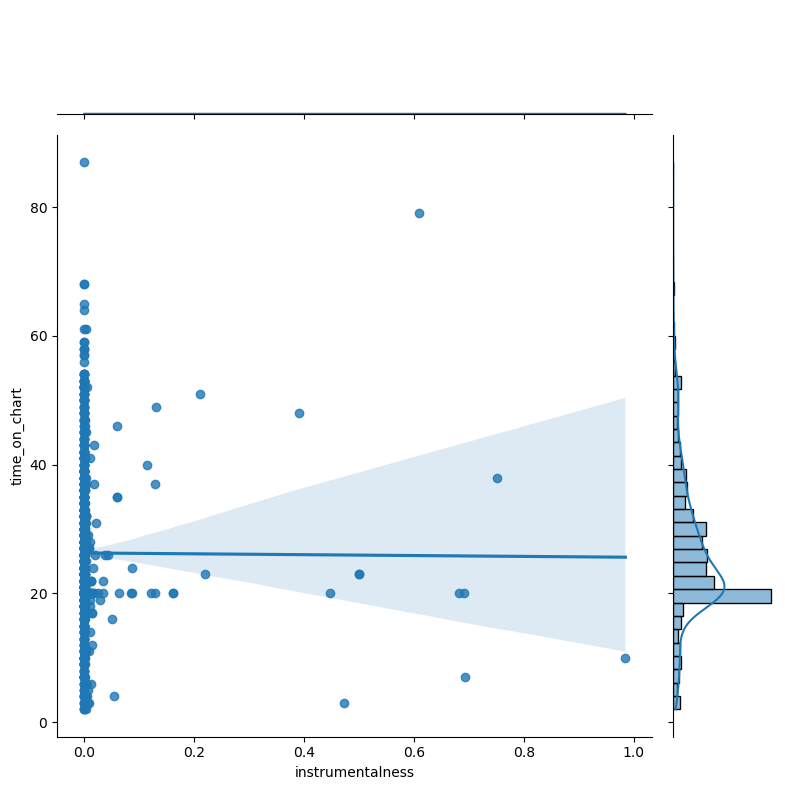

### Hypothesis:

$H_0$: There is no relationship between `instrumentalness` to `time_on_chart`

$H_A$: There is a relationship between `instrumentalness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.0039098680740875386`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between instrumentalness and time_on_chart. (p-value: 0.8961)

<hr style="border:2px solid gray">

# Question #12:

# Does a higher liveness mean higher time_on_chart?

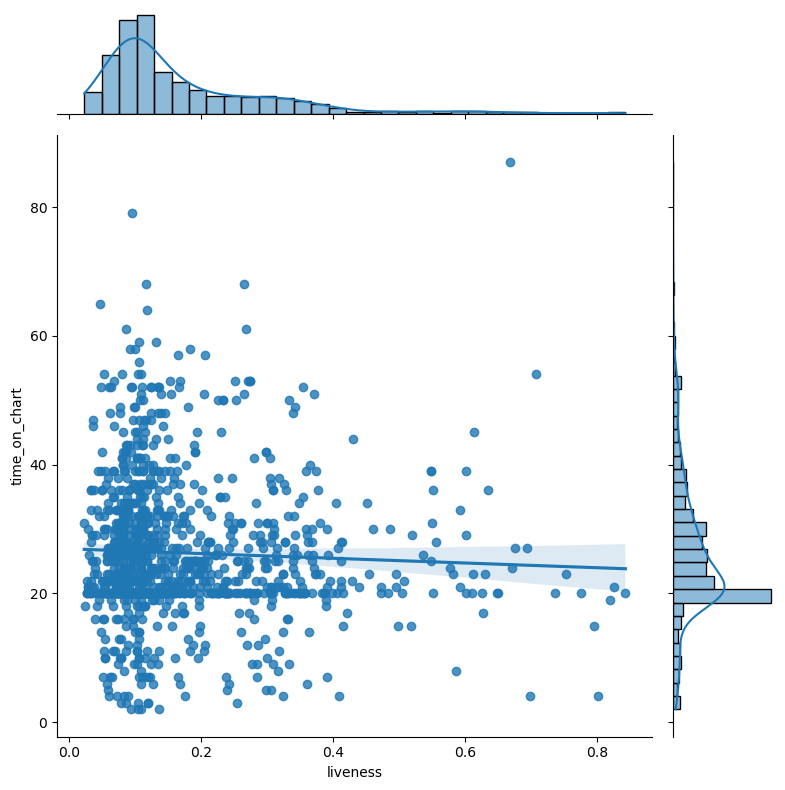

### Hypothesis:

$H_0$: There is no relationship between `liveness` to `time_on_chart`

$H_A$: There is a relationship between `liveness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.04477949881438156`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between liveness and time_on_chart. (p-value: 0.1344)

<hr style="border:2px solid gray">

# Question #13:

# Does a higher valence mean higher time_on_chart?

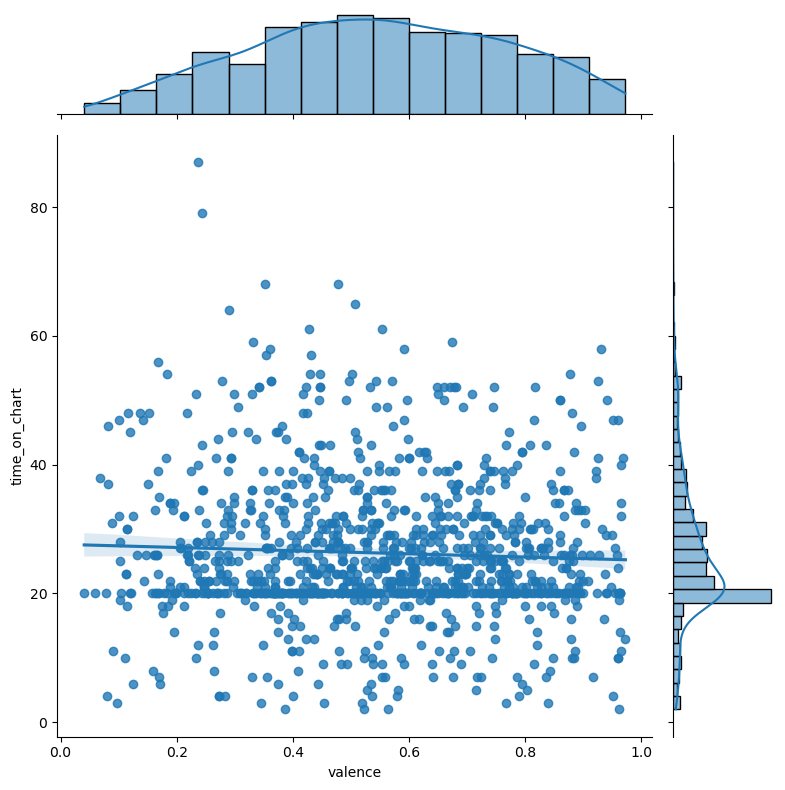

### Hypothesis:

$H_0$: There is no relationship between `valence` to `time_on_chart`

$H_A$: There is a relationship between `valence` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.048658073003431425`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between valence and time_on_chart. (p-value: 0.1038)

<hr style="border:2px solid gray">

# Question #14:

# Does a higher tempo mean higher time_on_chart?

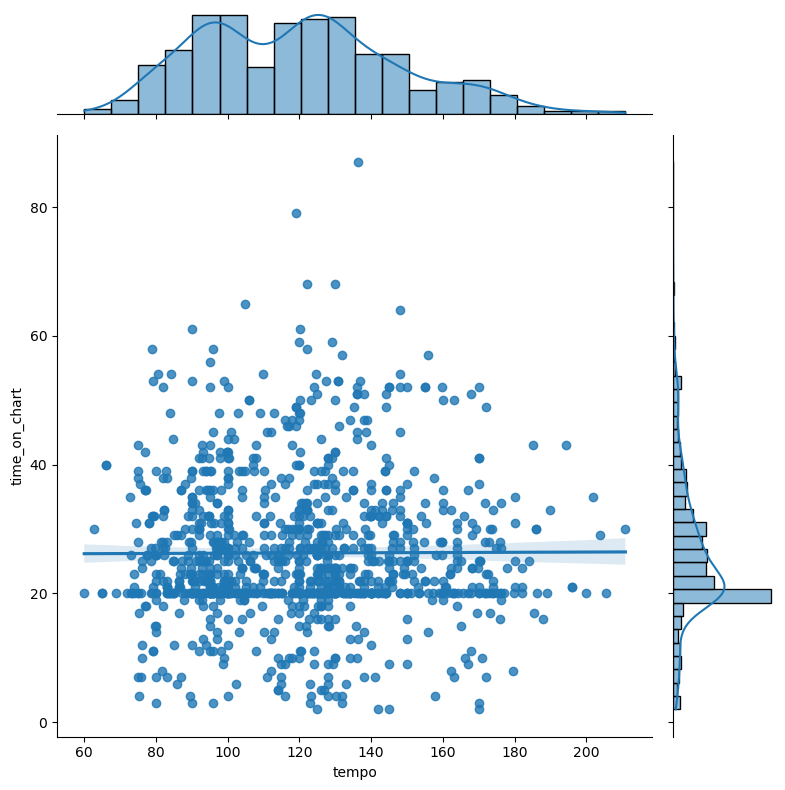

### Hypothesis:

$H_0$: There is no relationship between `tempo` to `time_on_chart`

$H_A$: There is a relationship between `tempo` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.004550615639695118`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between tempo and time_on_chart. (p-value: 0.8791)

<hr style="border:2px solid gray">

# Question #15:

# Does a higher chart_position mean higher time_on_chart?

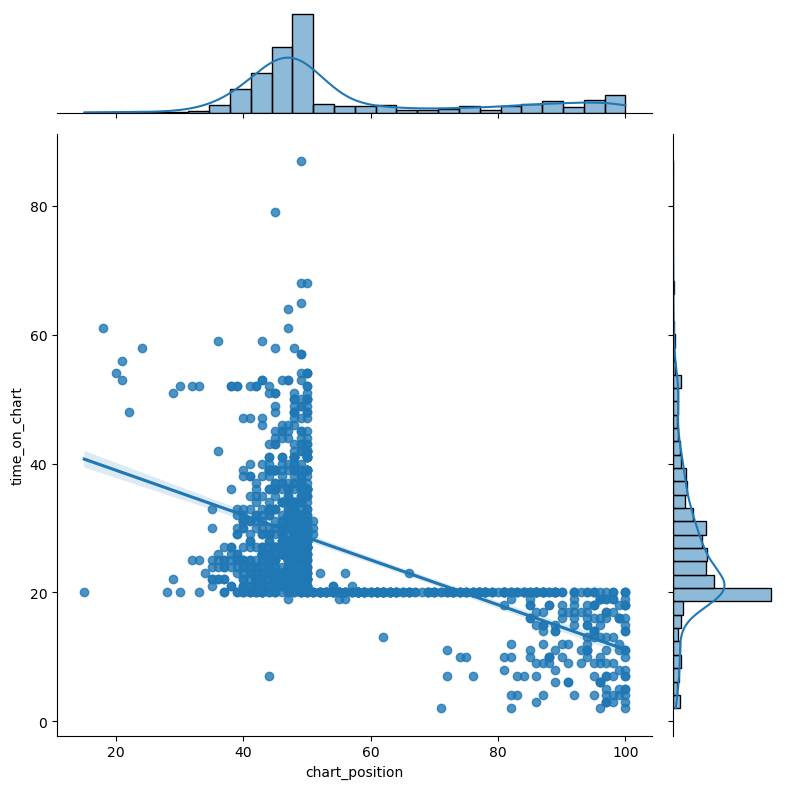

### Hypothesis:

$H_0$: There is no relationship between `chart_position` to `time_on_chart`

$H_A$: There is a relationship between `chart_position` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.5898503532806659`

### Results:

### Reject $H_0$

There exists some relationship between chart_position and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

write code for different test


# Question #17:

# Does a higher time_on_chart mean higher time_on_chart?

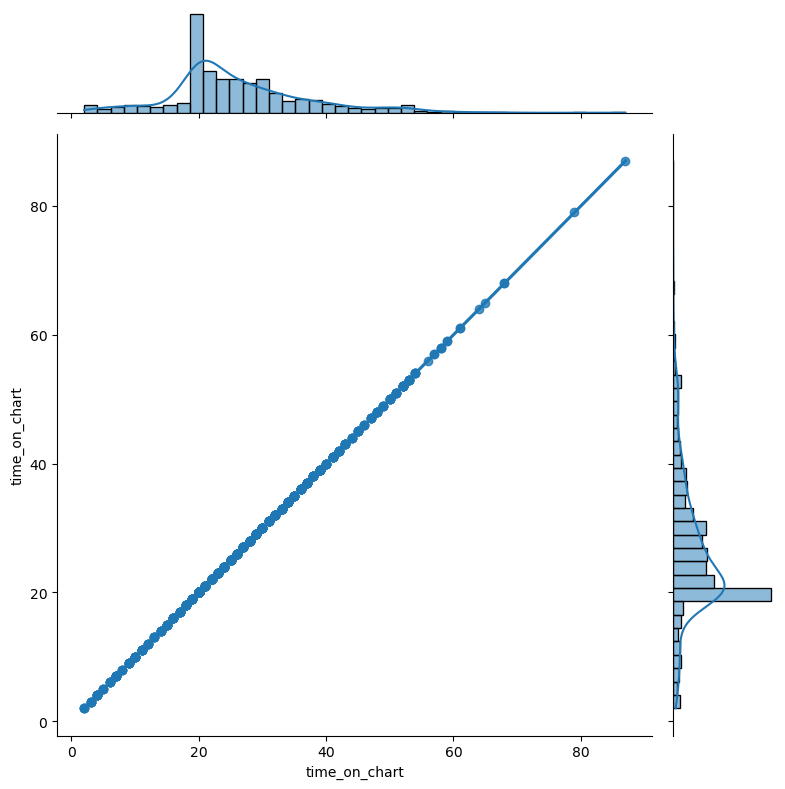

### Hypothesis:

$H_0$: There is no relationship between `time_on_chart` to `time_on_chart`

$H_A$: There is a relationship between `time_on_chart` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 1.0`

### Results:

### Reject $H_0$

There exists some relationship between time_on_chart and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #18:

# Does a higher consecutive_weeks mean higher time_on_chart?

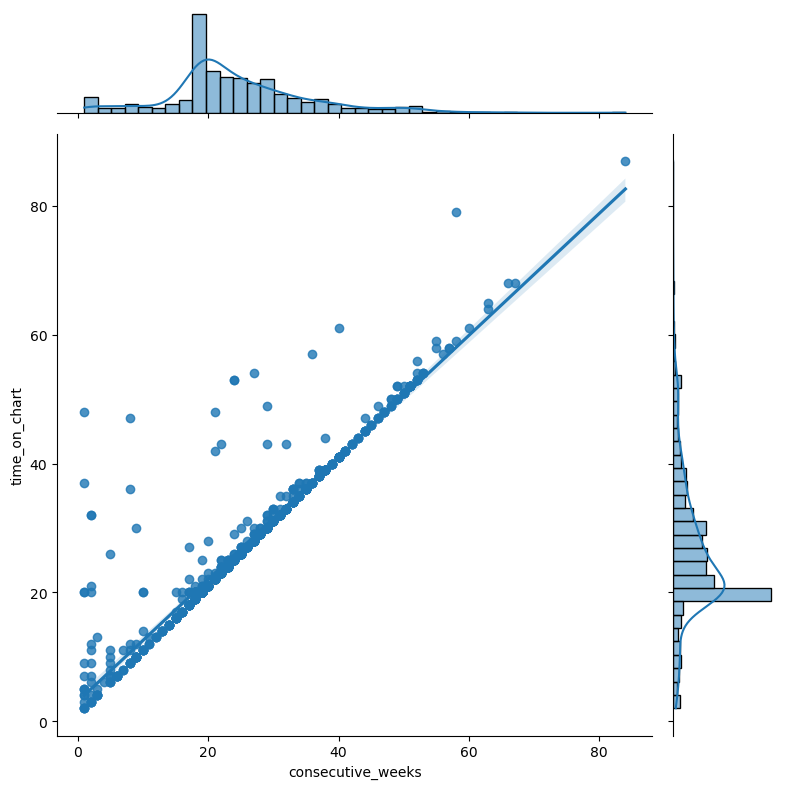

### Hypothesis:

$H_0$: There is no relationship between `consecutive_weeks` to `time_on_chart`

$H_A$: There is a relationship between `consecutive_weeks` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.9433128833292955`

### Results:

### Reject $H_0$

There exists some relationship between consecutive_weeks and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #19:

# Does a higher previous_week mean higher time_on_chart?

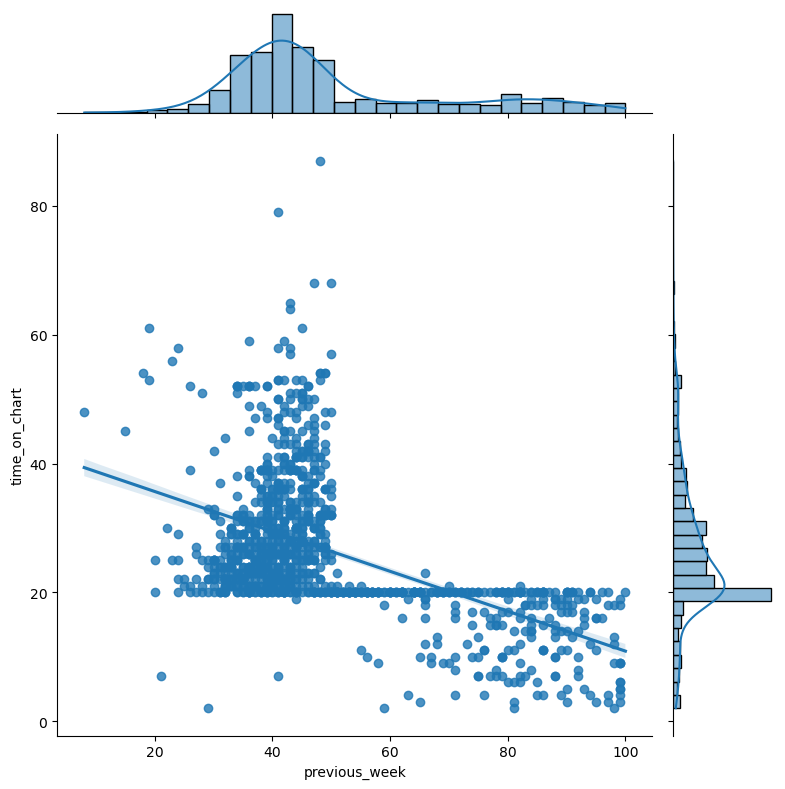

### Hypothesis:

$H_0$: There is no relationship between `previous_week` to `time_on_chart`

$H_A$: There is a relationship between `previous_week` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.5175025456219732`

### Results:

### Reject $H_0$

There exists some relationship between previous_week and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #20:

# Does a higher peak_position mean higher time_on_chart?

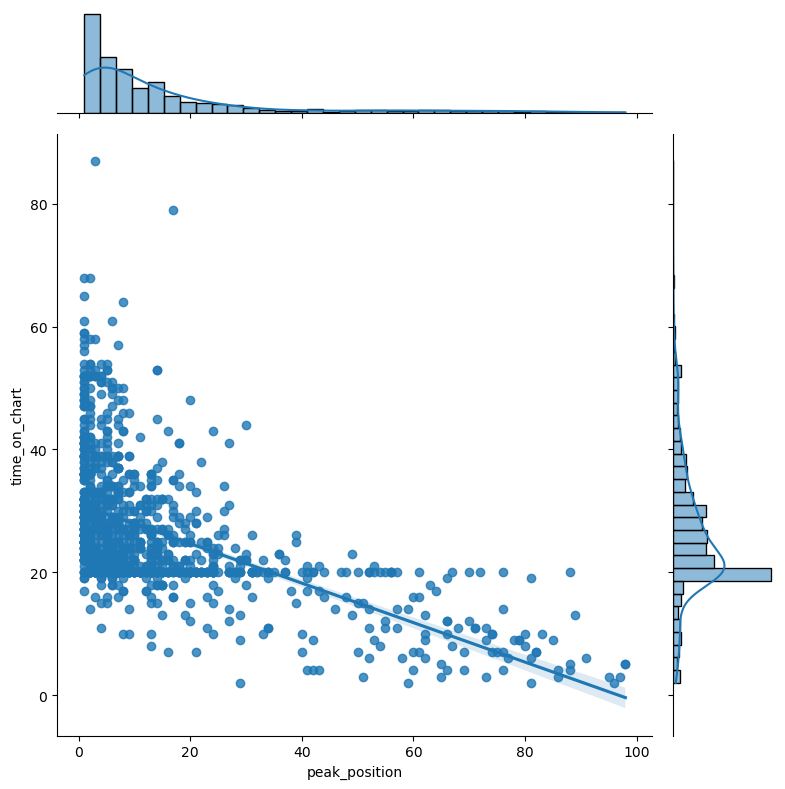

### Hypothesis:

$H_0$: There is no relationship between `peak_position` to `time_on_chart`

$H_A$: There is a relationship between `peak_position` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.5543648054633901`

### Results:

### Reject $H_0$

There exists some relationship between peak_position and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #21:

# Does a higher worst_position mean higher time_on_chart?

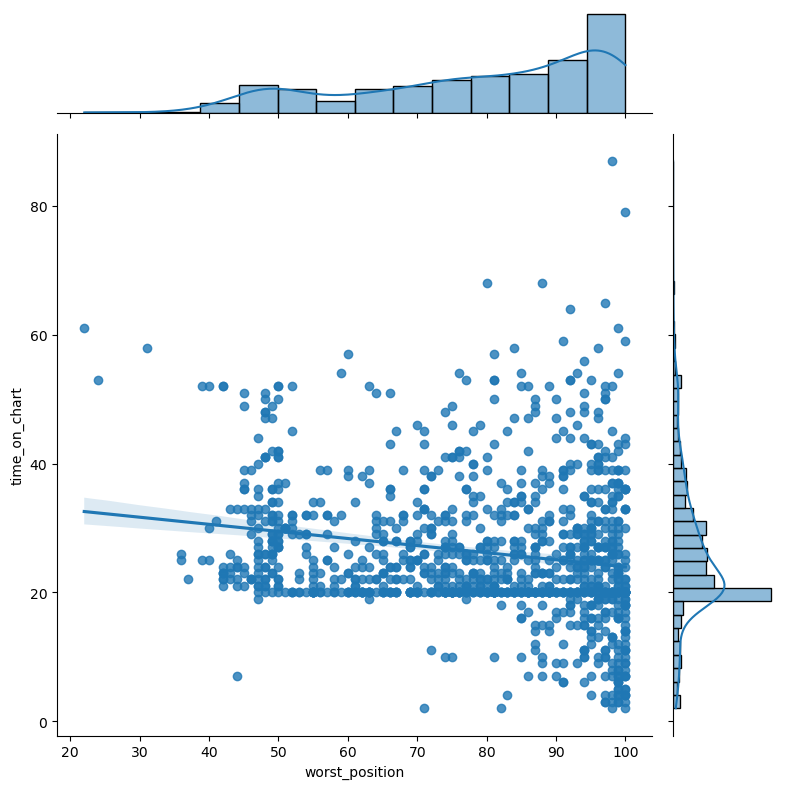

### Hypothesis:

$H_0$: There is no relationship between `worst_position` to `time_on_chart`

$H_A$: There is a relationship between `worst_position` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.17853680098392166`

### Results:

### Reject $H_0$

There exists some relationship between worst_position and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

In [20]:
num_columns_list = df.select_dtypes('number').columns
for num,feature in enumerate(num_columns_list):
    question_hypothesis_test((num+1),df,feature,target)

# Model <a id="model"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

### Pre-Process Obvious Continous Data Target Leakage

In [ ]:
df = df.drop(columns = ['chart_position', 'instance','popularity',
       'consecutive_weeks', 'previous_week', 'peak_position',
       'worst_position'])

### Split

In [220]:
train, val, test = split_data(df)

(626, 22) (269, 22) (224, 22)


### Isolate

In [221]:
X_train, y_train = isolate_target(train,target)

(626, 21) (626,)


In [222]:
X_validate, y_validate = isolate_target(val,target)

(269, 21) (269,)


In [223]:
X_test, y_test = isolate_target(test,target)

(224, 21) (224,)


### Scale <a id="scale"></a>

<a id="definitions"></a> [Definitions](#scale_def)

In [224]:
X_train_scaled = scale_data(X_train)
X_validate_scaled = scale_data(X_validate)
X_test_scaled = scale_data(X_test)

### Dummies

[Definitions](#dummy_def) <a id="get_dummies"></a>

In [225]:
to_dummies = ['explicit']

In [226]:
X_train_scaled = dummies(X_train_scaled,to_dummies)
X_validate_scaled = dummies(X_validate_scaled,to_dummies)
X_test_scaled = dummies(X_test_scaled,to_dummies)

### Models <a id="modeling"></a>

[Definitions](#model_def)

#### Step 1: Feature Selection Models

#### Method 1 - F-Regression

In [227]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [228]:
f_feature

['explicit', 'year', 'mode', 'speechiness']

#### Method 2: RFE

In [229]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train_scaled, y_train)

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['duration_ms', 'energy', 'loudness', 'valence']

In [230]:
var_ranks = rfe.ranking_

# get the variable names
var_names = X_train_scaled.columns.tolist()

# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

#### Step 2: Keeping Best Features From Both Methods

In [231]:
# Keeping Rank >= 7
modeling_features = rfe_ranks_df[rfe_ranks_df['Rank']<=7].sort_values('Rank')
modeling_features = [modeling_features.iloc[i][0] for i in range(10)]
modeling_features.append(to_dummies)
modeling_features = flatten(modeling_features)

In [232]:
# removing uneeded features after RFE
X_train_scaled = X_train_scaled[modeling_features]
X_validate_scaled = X_validate_scaled[modeling_features]
X_test_scaled = X_test_scaled[modeling_features]

#### Step 3: Fit Models

In [240]:
# Linear Model
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
preds['linear'] = lm.predict(X_train_scaled)

In [241]:
preds

,actual,baseline,linear
144,23.0,25.785942,23.066585
3,20.0,25.785942,24.107407
1021,41.0,25.785942,28.060050
473,39.0,25.785942,24.464882
1035,18.0,25.785942,31.022462
...,...,...,...
614,20.0,25.785942,29.256422
666,20.0,25.785942,26.458961
965,26.0,25.785942,27.654149
890,30.0,25.785942,25.052279


<a id="lasso"></a> [Definitions](#scale_def)

In [242]:
# Specific Scaling for Lasso Lars
X_train_lasso_scale = scale_data(X_train,mode="standard")
X_train_lasso_scale = dummies(X_train_lasso_scale,to_dummies)

# Lasso Lars Model
lars = LassoLars(alpha=1.0)
lars.fit(X_train_lasso_scale, y_train)
preds['lasso_lars'] = lars.predict(X_train_lasso_scale)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [243]:
# Tweedie Model
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train_scaled, y_train)
preds['Tweedie'] = glm.predict(X_train_scaled)

# Evaluate <a id="evaluate"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

### Baseline

In [244]:
# Baseline
preds['actual'] = y_train
preds['baseline'] = y_train.mean()

In [245]:
# Baseline RMSE Metric
print(f"Baseline RMSE = {(sqrt(mean_squared_error(preds['actual'], preds['baseline'])))}")

Baseline RMSE = 10.948128955492157


In [249]:
# Linear RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['linear']))

10.713153810120717

In [250]:
#  RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['lasso_lars']))

10.948128955492157

In [251]:
#  RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['Tweedie']))

10.711094490195787

In [252]:
preds

,actual,baseline,linear,lasso_lars,Tweedie
144,23.0,25.785942,23.066585,25.785942,23.072080
3,20.0,25.785942,24.107407,25.785942,24.094143
1021,41.0,25.785942,28.060050,25.785942,28.094595
473,39.0,25.785942,24.464882,25.785942,24.418431
1035,18.0,25.785942,31.022462,25.785942,31.508637
...,...,...,...,...,...
614,20.0,25.785942,29.256422,25.785942,29.385179
666,20.0,25.785942,26.458961,25.785942,26.383899
965,26.0,25.785942,27.654149,25.785942,27.570675
890,30.0,25.785942,25.052279,25.785942,24.964206


# Test <a id="test"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

# Summary <a id="summary"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

# Takeaways <a id="takeaways"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

# Next Steps <a id="takeaways"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

Readme, More Functions, Visualize Results, Visualize Test